# Week9: GAN

## 实验要求与基本流程

### 实验要求
1. 结合理论课内容，深入理解GAN(Generative Adversarial Networks,生成对抗网络)的原理与训练过程.了解GAN网络结构的演变过程与几个基本的GAN的原理(如DCGAN,LSGAN,wGAN等.)
2. 阅读实验指导书的实验内容,按照提示运行以及补充实验代码,或者简要回答问题.提交作业时,保留实验结果.

### 知识预备
1. 
2. 

### 实验流程
* GAN
* DCGAN
* LSGAN
* WGAN
* WGAN-GP

## GAN(Generative Adversarial Networks)

让我们先来看一个只是用线性层的生成对抗网络(GAN),来简单了解一下GAN的基本网络结构与训练过程.

这个GAN网络结构分为两部分,生成器网络Generator和判别器网络Discriminator.
- 生成器Generator将随机生成的噪声z通过多个线性层生成图片,注意生成器的最后一层是Tanh,所以我们生成的图片的取值范围为\[-1,1\],同理,我们会将真实图片归一化(normalize)到\[-1,1\].
- 而判别器Discriminator是一个二分类器,通过多个线性层得到一个概率值来判别图片是"真实"或者是"生成"的,所以在Discriminator的最后是一个sigmoid,来得到图片是"真实"的概率.

在所有的网络结构中我们都使用了LeakyReLU作为激活函数,除了G与D的最后一层,同时,我们在层与层之间我们还加入了BatchNormalization.

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Generator(nn.Module):
    def __init__(self, image_size=32, latent_dim=100, output_channel=1):
        """
        image_size: image with and height
        latent dim: the dimension of random noise z
        output_channel: the channel of generated image, for example, 1 for gray image, 3 for RGB image
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_channel = output_channel
        self.image_size = image_size
        
        # Linear layer: latent_dim -> 128 -> 256 -> 512 -> 1024 -> output_channel * image_size * image_size -> Tanh
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, output_channel * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.output_channel, self.image_size, self.image_size)
        return img


class Discriminator(nn.Module):
    def __init__(self, image_size=32, input_channel=1):
        """
        image_size: image with and height
        input_channel: the channel of input image, for example, 1 for gray image, 3 for RGB image
        """
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.input_channel = input_channel
        
        # Linear layer: input_channel * image_size * image_size -> 1024 -> 512 -> 256 -> 1 -> Sigmoid
        self.model = nn.Sequential(
            nn.Linear(input_channel * image_size * image_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        out = self.model(img_flat)
        return out

### 数据集
在训练我们的GAN网络之前, 先介绍一下本次实验可训练GAN的数据集,我们提供了两个数据集来供大家进行尝试数据集.
- MNIST手写体3类数据集,这里为了加快我们的训练速度,我们提供了一个简化版本的只包含数字0,1,2的3类MNIST数据集,每类各1000张.图片为28\*28的单通道灰度图(我们将其resize到32\*32),对于GAN而言,我们不需要测试集.我们本次实验主要使用该数据集作为主要的训练数据集.

-----------------数据集示例图片-------------------------

- 室内家具数据集.包含bed,chair,couch等五个类,每个类各500张.图片为32\*32的3通道彩色图片,这个数据集训练难度较高,有兴趣的同学可以尝试使用GAN来生成相似的图片.

-----------------数据集示例图片-------------------------

下面是两个加载数据集的函数.注意我们将所有图片normalize到了\[-1,1\]之间.


In [7]:
def load_mnist_data():
    """
    load mnist(0,1,2) dataset 
    """
    
    transform = torchvision.transforms.Compose([
        # transform to 1-channel gray image since we reading image in RGB mode
        transforms.Grayscale(1),
        # resize image from 28 * 28 to 32 * 32
        transforms.Resize(32),
        transforms.ToTensor(),
        # normalize with mean=0.5 std=0.5
        transforms.Normalize(mean=(0.5, ), 
                             std=(0.5, ))
        ])
    
    train_dataset = torchvision.datasets.ImageFolder(root='./data/mnist', transform=transform)
    
    return train_dataset

def load_furniture_data():
    """
    load furniture dataset 
    """
    transform = torchvision.transforms.Compose([
        transforms.ToTensor(),
        # normalize with mean=0.5 std=0.5
        transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                             std=(0.5, 0.5, 0.5))
        ])
    train_dataset = torchvision.datasets.ImageFolder(root='./data/household_furniture', transform=transform)
    return train_dataset

(*无需阅读理解*)运行下面2个cell的代码来查看两个数据集中的20张随机真实图片.

In [8]:
def denorm(x):
    # denormalize
    out = (x + 1) / 2
    return out.clamp(0, 1)

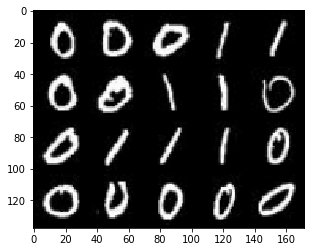

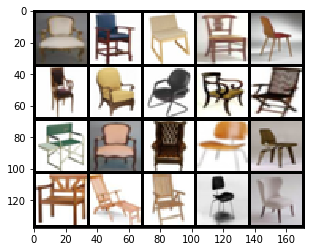

In [9]:
from utils import show
"""
you can pass code in this cell
"""
# show mnist real data
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
show(torchvision.utils.make_grid(denorm(next(iter(trainloader))[0]), nrow=5))
# show furniture real data
train_dataset = load_furniture_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
show(torchvision.utils.make_grid(denorm(next(iter(trainloader))[0]), nrow=5))

下面代码实现GAN在一个epoch内的训练过程.

大体而言,GAN的训练过程分为两步,首先将随机噪声z喂给G,生成图片,然后将真实图片和G生成的图片喂给D,然后使用对应的loss函数反向传播优化D.然后再次使用G生成图片,并喂给D,并使用对应的loss函数反向传播优化G.

下面的图片是普通的GAN在G和D上的优化目标:
![gan_d](./pictures/gan_d.png)
![gan_g](./pictures/gan_g.png)
值得注意的是,上述图片描述的是G和D的**优化目标**,而在具体实现过程中,我们实现loss函数来达到优化目标.对于上图中D与G的优化目标我们可以使用Binary Cross Entroy损失函数来实现:
$$
BCEloss(p_i,y_i)= -(y_i\log{p_i}+(1−y_i)\log{(1−p_i)})
$$
$p_i$, $y_i$分别是模型的预测值与图片的真实标签(1为真,0为假).因此,对于D,最大化其优化目标可以通过最小化一个BCEloss来实现,其真实图片$x\sim{P_r}$的标签设置为1,而生成图片$z\sim{P(z)}$的标签设置为0.我们可以看到这样的损失函数相当于对D的优化目标加上负号.

而对于G,也通过最小化一个BCEloss来实现,即将生成图片$z\sim{P(z)}$的标签设置为1即可,我们可以看到这样的损失函数与其优化目标是一致的.

In [10]:
def train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, z_dim):
    """
    train a GAN with model G and D in one epoch
    Args:
        trainloader: data loader to train
        G: model Generator
        D: model Discriminator
        G_optimizer: optimizer of G(etc. Adam, SGD)
        D_optimizer: optimizer of D(etc. Adam, SGD)
        loss_func: loss function to train G and D. For example, Binary Cross Entropy(BCE) loss function
        device: cpu or cuda device
        z_dim: the dimension of random noise z
    """
    # set train mode
    D.train()
    G.train()
    
    D_total_loss = 0
    G_total_loss = 0
    
    
    for i, (x, _) in enumerate(trainloader):
        # real label and fake label
        y_real = torch.ones(x.size(0), 1).to(device)
        y_fake = torch.zeros(x.size(0), 1).to(device)
        
        x = x.to(device)
        z = torch.rand(x.size(0), z_dim).to(device)

        # update D network
        # D optimizer zero grads
        D_optimizer.zero_grad()
        
        # D real loss from real images
        d_real = D(x)
        d_real_loss = loss_func(d_real, y_real)
        
        # D fake loss from fake images generated by G
        g_z = G(z)
        d_fake = D(g_z)
        d_fake_loss = loss_func(d_fake, y_fake)
        
        # D backward and step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()

        # update G network
        # G optimizer zero grads
        G_optimizer.zero_grad()
        
        # G loss
        g_z = G(z)
        d_fake = D(g_z)
        g_loss = loss_func(d_fake, y_real)
        
        # G backward and step
        g_loss.backward()
        G_optimizer.step()
        
        D_total_loss += d_loss.item()
        G_total_loss += g_loss.item()
    
    return D_total_loss / len(trainloader), G_total_loss / len(trainloader)

当模型训练后,我们需要查看此时G生成的图片效果,下面的visualize_results代码便实现了这块内容.注意,我们生成的图片都在\[-1,1\],因此,我们需要将图片反向归一化(denorm)到\[0,1\].

In [11]:
def visualize_results(G, device, z_dim, result_size=20):
    G.eval()
    
    z = torch.rand(result_size, z_dim).to(device)
    g_z = G(z)
    
    show(torchvision.utils.make_grid(denorm(g_z.detach().cpu()), nrow=5))

万事具备,接下来让我们来尝试这训练一个基本的GAN网络吧.这里实现run_gan函数来调用train以及visualize_results来训练我们的GAN.

In [12]:
def run_gan(trainloader, G, D, G_optimizer, D_optimizer, loss_func, n_epochs, device, latent_dim):
    d_loss_hist = []
    g_loss_hist = []

    for epoch in range(n_epochs):
        d_loss, g_loss = train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, 
                               z_dim=latent_dim)
        print('Epoch {}: Train D loss: {:.4f}, G loss: {:.4f}'.format(epoch, d_loss, g_loss))

        d_loss_hist.append(d_loss)
        g_loss_hist.append(g_loss)

        if epoch == 0 or (epoch + 1) % 10 == 0:
            visualize_results(G, device, latent_dim) 
    
    return d_loss_hist, g_loss_hist

设置好超参数就可以开始训练!

In [13]:
# hyper params

# z dim
latent_dim = 100

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 100
batch_size = 32

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# use BCELoss as loss function
bceloss = nn.BCELoss().to(device)

# G and D model
G = Generator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel).to(device)
D = Discriminator(image_size=image_size, input_channel=image_channel).to(device)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

Epoch 0: Train D loss: 1.1771, G loss: 0.7957


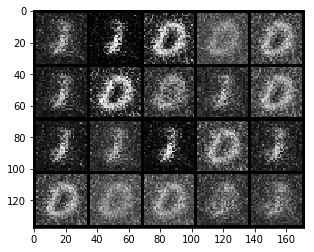

Epoch 1: Train D loss: 1.2315, G loss: 0.9083
Epoch 2: Train D loss: 1.1786, G loss: 0.9988
Epoch 3: Train D loss: 1.1470, G loss: 1.0078
Epoch 4: Train D loss: 1.1271, G loss: 1.0530
Epoch 5: Train D loss: 1.1409, G loss: 1.0940
Epoch 6: Train D loss: 1.1329, G loss: 1.1341
Epoch 7: Train D loss: 1.0879, G loss: 1.1934
Epoch 8: Train D loss: 1.0926, G loss: 1.1863
Epoch 9: Train D loss: 1.0521, G loss: 1.2486


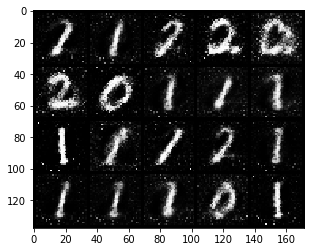

Epoch 10: Train D loss: 1.0969, G loss: 1.1937
Epoch 11: Train D loss: 1.1265, G loss: 1.1420
Epoch 12: Train D loss: 1.0959, G loss: 1.1738
Epoch 13: Train D loss: 1.0938, G loss: 1.1997
Epoch 14: Train D loss: 1.1013, G loss: 1.2199
Epoch 15: Train D loss: 1.0904, G loss: 1.2080
Epoch 16: Train D loss: 1.1275, G loss: 1.1665
Epoch 17: Train D loss: 1.0961, G loss: 1.2229
Epoch 18: Train D loss: 1.1081, G loss: 1.1940
Epoch 19: Train D loss: 1.1146, G loss: 1.1988


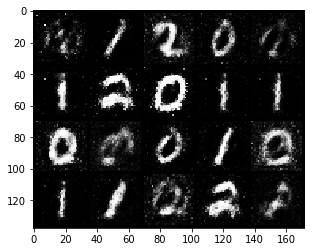

Epoch 20: Train D loss: 1.1221, G loss: 1.1771
Epoch 21: Train D loss: 1.1131, G loss: 1.2116
Epoch 22: Train D loss: 1.0906, G loss: 1.2332
Epoch 23: Train D loss: 1.1109, G loss: 1.1995
Epoch 24: Train D loss: 1.1133, G loss: 1.2027
Epoch 25: Train D loss: 1.0998, G loss: 1.2470
Epoch 26: Train D loss: 1.1088, G loss: 1.2271
Epoch 27: Train D loss: 1.1103, G loss: 1.2245
Epoch 28: Train D loss: 1.1428, G loss: 1.1797
Epoch 29: Train D loss: 1.1278, G loss: 1.1846


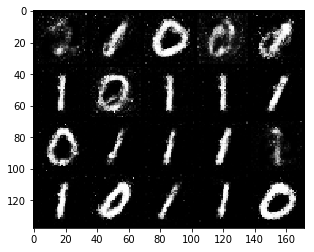

Epoch 30: Train D loss: 1.1126, G loss: 1.2198
Epoch 31: Train D loss: 1.1394, G loss: 1.1767
Epoch 32: Train D loss: 1.1218, G loss: 1.1919
Epoch 33: Train D loss: 1.1454, G loss: 1.1947
Epoch 34: Train D loss: 1.1605, G loss: 1.1671
Epoch 35: Train D loss: 1.1553, G loss: 1.1612
Epoch 36: Train D loss: 1.1376, G loss: 1.1711
Epoch 37: Train D loss: 1.1369, G loss: 1.1736
Epoch 38: Train D loss: 1.1487, G loss: 1.1900
Epoch 39: Train D loss: 1.1451, G loss: 1.1818


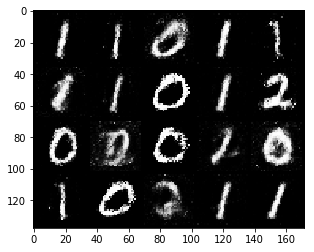

Epoch 40: Train D loss: 1.1345, G loss: 1.1878
Epoch 41: Train D loss: 1.1409, G loss: 1.1864
Epoch 42: Train D loss: 1.1414, G loss: 1.1764
Epoch 43: Train D loss: 1.1453, G loss: 1.1974
Epoch 44: Train D loss: 1.1387, G loss: 1.1979
Epoch 45: Train D loss: 1.1472, G loss: 1.1823
Epoch 46: Train D loss: 1.1425, G loss: 1.1938
Epoch 47: Train D loss: 1.1398, G loss: 1.2117
Epoch 48: Train D loss: 1.1387, G loss: 1.2231
Epoch 49: Train D loss: 1.1249, G loss: 1.2110


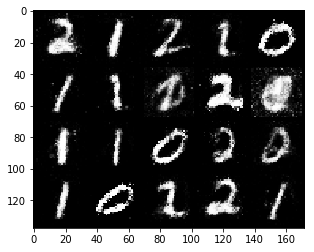

Epoch 50: Train D loss: 1.1341, G loss: 1.2148
Epoch 51: Train D loss: 1.1223, G loss: 1.2089
Epoch 52: Train D loss: 1.1126, G loss: 1.2289
Epoch 53: Train D loss: 1.1275, G loss: 1.2310
Epoch 54: Train D loss: 1.1213, G loss: 1.2410
Epoch 55: Train D loss: 1.1146, G loss: 1.2615
Epoch 56: Train D loss: 1.1229, G loss: 1.2535
Epoch 57: Train D loss: 1.1112, G loss: 1.2423
Epoch 58: Train D loss: 1.1237, G loss: 1.2409
Epoch 59: Train D loss: 1.1161, G loss: 1.2593


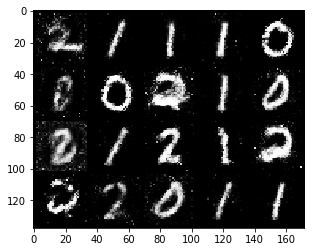

Epoch 60: Train D loss: 1.1204, G loss: 1.2479
Epoch 61: Train D loss: 1.1154, G loss: 1.2451
Epoch 62: Train D loss: 1.1077, G loss: 1.2787
Epoch 63: Train D loss: 1.1022, G loss: 1.2856
Epoch 64: Train D loss: 1.0917, G loss: 1.2846
Epoch 65: Train D loss: 1.1071, G loss: 1.2683
Epoch 66: Train D loss: 1.0996, G loss: 1.2632
Epoch 67: Train D loss: 1.1038, G loss: 1.2496
Epoch 68: Train D loss: 1.0907, G loss: 1.2611
Epoch 69: Train D loss: 1.0900, G loss: 1.2923


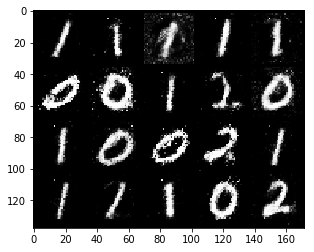

Epoch 70: Train D loss: 1.0908, G loss: 1.2726
Epoch 71: Train D loss: 1.0880, G loss: 1.2921
Epoch 72: Train D loss: 1.0754, G loss: 1.3068
Epoch 73: Train D loss: 1.0822, G loss: 1.2856
Epoch 74: Train D loss: 1.0827, G loss: 1.2926
Epoch 75: Train D loss: 1.0622, G loss: 1.2985
Epoch 76: Train D loss: 1.0851, G loss: 1.2881
Epoch 77: Train D loss: 1.0865, G loss: 1.2717
Epoch 78: Train D loss: 1.0661, G loss: 1.3009
Epoch 79: Train D loss: 1.0645, G loss: 1.3044


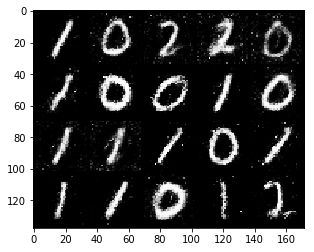

Epoch 80: Train D loss: 1.0795, G loss: 1.2790
Epoch 81: Train D loss: 1.0761, G loss: 1.2928
Epoch 82: Train D loss: 1.0851, G loss: 1.3215
Epoch 83: Train D loss: 1.0964, G loss: 1.2868
Epoch 84: Train D loss: 1.0845, G loss: 1.3265
Epoch 85: Train D loss: 1.0706, G loss: 1.3183
Epoch 86: Train D loss: 1.0773, G loss: 1.3287
Epoch 87: Train D loss: 1.0678, G loss: 1.3284
Epoch 88: Train D loss: 1.0853, G loss: 1.3182
Epoch 89: Train D loss: 1.0895, G loss: 1.3131


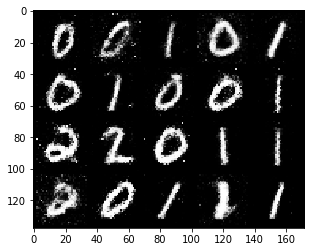

Epoch 90: Train D loss: 1.0765, G loss: 1.3061
Epoch 91: Train D loss: 1.0953, G loss: 1.3094
Epoch 92: Train D loss: 1.0725, G loss: 1.3292
Epoch 93: Train D loss: 1.0584, G loss: 1.3006
Epoch 94: Train D loss: 1.0649, G loss: 1.3240
Epoch 95: Train D loss: 1.0756, G loss: 1.3303
Epoch 96: Train D loss: 1.0830, G loss: 1.3125
Epoch 97: Train D loss: 1.0761, G loss: 1.3415
Epoch 98: Train D loss: 1.0541, G loss: 1.3345
Epoch 99: Train D loss: 1.0728, G loss: 1.3418


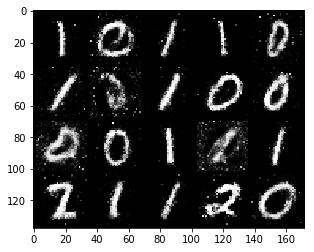

In [22]:
d_loss_hist, g_loss_hist = run_gan(trainloader, G, D, G_optimizer, D_optimizer, bceloss, 
                                   n_epochs, device, latent_dim)
    

训练完后,让我们来看一下G生成的图片效果,以及G和D的loss变化曲线(运行下方语句.)

In [11]:
from utils import loss_plot

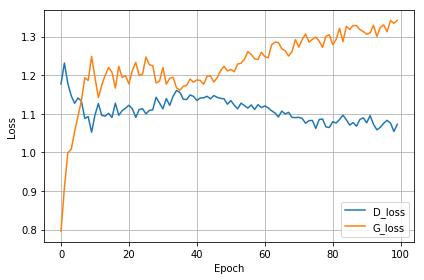

In [24]:
loss_plot(d_loss_hist, g_loss_hist)

#### **作业**:
观察G与D的loss曲线,与之前的训练的CNN的loss曲线相比,有什么不同?试简要回答你觉得可能产生这样的不同的原因.

**答:**

## DCGAN

在DCGAN(Deep Convolution GAN)中,最大的改变是使用了CNN代替全连接层.在生成器G中,使用stride为2的转置卷积来生成图片同时扩大图片尺寸,而在判别器D中,使用stride为2的卷积来将图片进行卷积并下采样.除此之外,DCGAN加入了在层与层之间BatchNormalization(虽然我们在普通的GAN中就已经添加),在G中使用ReLU作为激活函数,而在D中使用LeakyReLU作为激活函数.

In [14]:
from utils import initialize_weights
class DCGenerator(nn.Module):
    def __init__(self, image_size=32, latent_dim=64, output_channel=1):
        super(DCGenerator, self).__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.output_channel = output_channel
        
        self.init_size = image_size // 8
        
        # fc: Linear -> BN -> ReLU
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * self.init_size ** 2),
            nn.BatchNorm1d(512 * self.init_size ** 2),
            nn.ReLU(inplace=True)
        )
        
        # deconv: ConvTranspose2d(4, 2, 1) -> BN -> ReLU -> 
        #         ConvTranspose2d(4, 2, 1) -> BN -> ReLU -> 
        #         ConvTranspose2d(4, 2, 1) -> Tanh
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, output_channel, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.deconv(out)
        return img


class DCDiscriminator(nn.Module):
    def __init__(self, image_size=32, input_channel=1, sigmoid=True):
        super(DCDiscriminator, self).__init__()
        self.image_size = image_size
        self.input_channel = input_channel
        self.fc_size = image_size // 8
        
        # conv: Conv2d(3,2,1) -> LeakyReLU 
        #       Conv2d(3,2,1) -> BN -> LeakyReLU 
        #       Conv2d(3,2,1) -> BN -> LeakyReLU 
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, 128, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # fc: Linear -> Sigmoid
        self.fc = nn.Sequential(
            nn.Linear(512 * self.fc_size * self.fc_size, 1),
        )
        if sigmoid:
            self.fc.add_module('sigmoid', nn.Sigmoid())
        initialize_weights(self)
        
        

    def forward(self, img):
        out = self.conv(img)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

同样的,我们使用同样的数据集对DCGAN进行训练.

In [15]:
# hyper params

# z dim
latent_dim = 100

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 100
batch_size = 32

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# use BCELoss as loss function
bceloss = nn.BCELoss().to(device)

# G and D model, use DCGAN
G = DCGenerator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel).to(device)
D = DCDiscriminator(image_size=image_size, input_channel=image_channel).to(device)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

Epoch 0: Train D loss: 0.2814, G loss: 5.3166


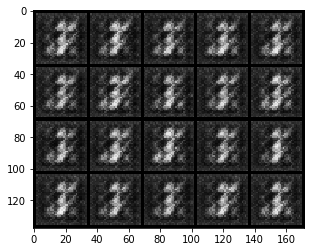

Epoch 1: Train D loss: 0.2959, G loss: 5.1354
Epoch 2: Train D loss: 0.2788, G loss: 3.8241
Epoch 3: Train D loss: 0.4283, G loss: 3.2125
Epoch 4: Train D loss: 0.4618, G loss: 2.9790
Epoch 5: Train D loss: 0.5141, G loss: 2.7515
Epoch 6: Train D loss: 0.3727, G loss: 2.8566
Epoch 7: Train D loss: 0.5541, G loss: 2.7711
Epoch 8: Train D loss: 0.5778, G loss: 2.2713
Epoch 9: Train D loss: 0.3842, G loss: 2.6700


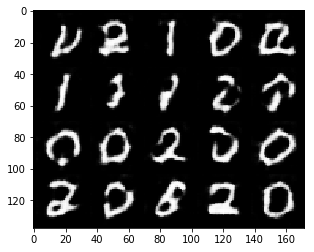

Epoch 10: Train D loss: 0.6301, G loss: 2.3045
Epoch 11: Train D loss: 0.3817, G loss: 2.7250
Epoch 12: Train D loss: 0.4457, G loss: 2.6573
Epoch 13: Train D loss: 0.5105, G loss: 2.5546
Epoch 14: Train D loss: 0.5540, G loss: 2.5346
Epoch 15: Train D loss: 0.4572, G loss: 2.5399
Epoch 16: Train D loss: 0.4943, G loss: 2.7225
Epoch 17: Train D loss: 0.3224, G loss: 2.8827
Epoch 18: Train D loss: 0.5794, G loss: 2.7069
Epoch 19: Train D loss: 0.5013, G loss: 2.5719


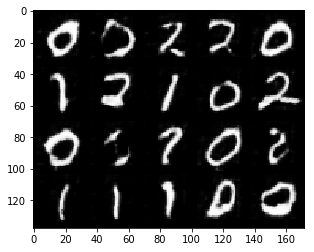

Epoch 20: Train D loss: 0.2867, G loss: 3.1814
Epoch 21: Train D loss: 0.5308, G loss: 2.9456
Epoch 22: Train D loss: 0.4396, G loss: 2.7983
Epoch 23: Train D loss: 0.3035, G loss: 3.2359
Epoch 24: Train D loss: 0.3333, G loss: 3.3708
Epoch 25: Train D loss: 0.2812, G loss: 3.4177
Epoch 26: Train D loss: 0.3605, G loss: 3.2367
Epoch 27: Train D loss: 0.1185, G loss: 4.0320
Epoch 28: Train D loss: 0.4826, G loss: 3.3659
Epoch 29: Train D loss: 0.1288, G loss: 4.0612


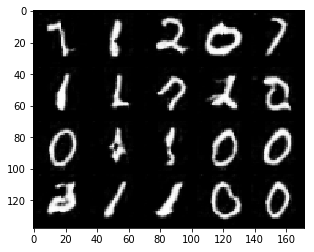

Epoch 30: Train D loss: 0.5429, G loss: 3.6942
Epoch 31: Train D loss: 0.2067, G loss: 3.7062
Epoch 32: Train D loss: 0.0776, G loss: 4.3898
Epoch 33: Train D loss: 0.5249, G loss: 3.6979
Epoch 34: Train D loss: 0.4018, G loss: 3.3719
Epoch 35: Train D loss: 0.0894, G loss: 4.1797
Epoch 36: Train D loss: 0.4987, G loss: 3.3029
Epoch 37: Train D loss: 0.0615, G loss: 4.4941
Epoch 38: Train D loss: 0.0402, G loss: 4.9344
Epoch 39: Train D loss: 0.5020, G loss: 4.2337


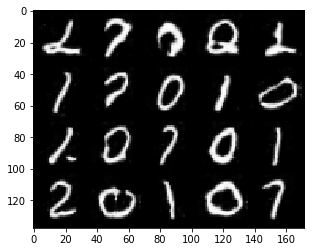

Epoch 40: Train D loss: 0.1128, G loss: 4.1543
Epoch 41: Train D loss: 0.0451, G loss: 4.7635
Epoch 42: Train D loss: 0.4308, G loss: 3.9896
Epoch 43: Train D loss: 0.2685, G loss: 4.0837
Epoch 44: Train D loss: 0.0392, G loss: 4.9993
Epoch 45: Train D loss: 0.0448, G loss: 5.2014
Epoch 46: Train D loss: 0.0218, G loss: 5.5439
Epoch 47: Train D loss: 0.7766, G loss: 3.4454
Epoch 48: Train D loss: 0.6276, G loss: 2.6111
Epoch 49: Train D loss: 0.3328, G loss: 3.4404


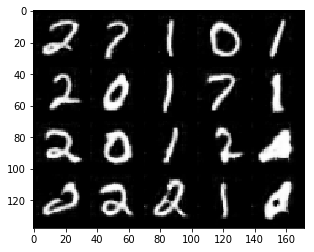

Epoch 50: Train D loss: 0.0716, G loss: 4.4554
Epoch 51: Train D loss: 0.0363, G loss: 5.0614
Epoch 52: Train D loss: 0.0254, G loss: 5.3483
Epoch 53: Train D loss: 0.0213, G loss: 5.5393
Epoch 54: Train D loss: 0.8682, G loss: 4.3871
Epoch 55: Train D loss: 0.5763, G loss: 3.0591
Epoch 56: Train D loss: 0.1835, G loss: 4.1109
Epoch 57: Train D loss: 0.0404, G loss: 4.8797
Epoch 58: Train D loss: 0.0293, G loss: 5.3171
Epoch 59: Train D loss: 0.0222, G loss: 5.4944


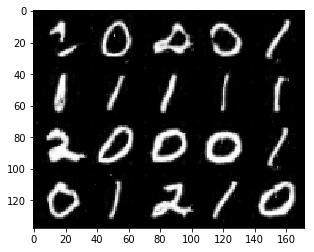

Epoch 60: Train D loss: 0.0187, G loss: 5.8204
Epoch 61: Train D loss: 0.0183, G loss: 5.8252
Epoch 62: Train D loss: 0.0145, G loss: 6.0682
Epoch 63: Train D loss: 0.0136, G loss: 6.2373
Epoch 64: Train D loss: 0.5166, G loss: 4.8968
Epoch 65: Train D loss: 0.5983, G loss: 3.4315
Epoch 66: Train D loss: 0.1487, G loss: 4.0541
Epoch 67: Train D loss: 0.2563, G loss: 4.1312
Epoch 68: Train D loss: 0.0347, G loss: 5.1730
Epoch 69: Train D loss: 0.0240, G loss: 5.5403


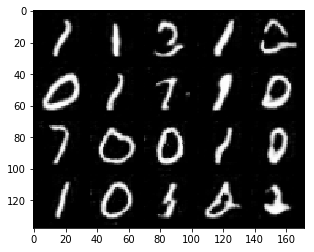

Epoch 70: Train D loss: 0.8507, G loss: 2.8521
Epoch 71: Train D loss: 0.3140, G loss: 3.7428
Epoch 72: Train D loss: 0.0385, G loss: 4.9130
Epoch 73: Train D loss: 0.0206, G loss: 5.5598
Epoch 74: Train D loss: 0.0164, G loss: 5.8158
Epoch 75: Train D loss: 0.0130, G loss: 5.9957
Epoch 76: Train D loss: 0.0125, G loss: 6.2844
Epoch 77: Train D loss: 0.0086, G loss: 6.3467
Epoch 78: Train D loss: 0.0090, G loss: 6.4325
Epoch 79: Train D loss: 0.0097, G loss: 6.4583


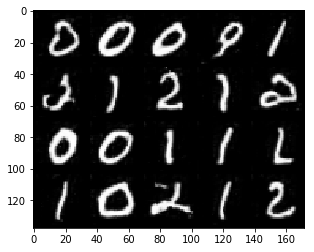

Epoch 80: Train D loss: 0.0091, G loss: 6.4677
Epoch 81: Train D loss: 0.0092, G loss: 6.7726
Epoch 82: Train D loss: 0.0061, G loss: 6.7639
Epoch 83: Train D loss: 0.7530, G loss: 4.8456
Epoch 84: Train D loss: 0.7289, G loss: 2.3161
Epoch 85: Train D loss: 0.5850, G loss: 2.7162
Epoch 86: Train D loss: 0.4953, G loss: 3.1652
Epoch 87: Train D loss: 0.4187, G loss: 3.4084
Epoch 88: Train D loss: 0.3096, G loss: 3.7376
Epoch 89: Train D loss: 0.0736, G loss: 4.4164


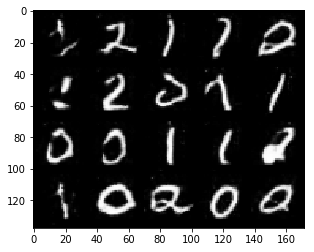

Epoch 90: Train D loss: 0.0334, G loss: 5.0408
Epoch 91: Train D loss: 0.0273, G loss: 5.4605
Epoch 92: Train D loss: 0.0193, G loss: 5.5720
Epoch 93: Train D loss: 0.0139, G loss: 5.8632
Epoch 94: Train D loss: 0.0121, G loss: 6.0325
Epoch 95: Train D loss: 0.0127, G loss: 6.1869
Epoch 96: Train D loss: 0.0099, G loss: 6.4695
Epoch 97: Train D loss: 0.4433, G loss: 5.4552
Epoch 98: Train D loss: 0.4027, G loss: 4.0135
Epoch 99: Train D loss: 0.0655, G loss: 4.8136


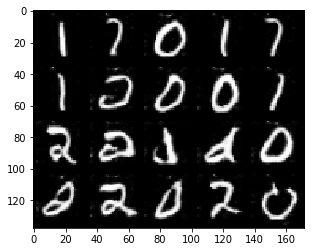

In [28]:
d_loss_hist, g_loss_hist = run_gan(trainloader, G, D, G_optimizer, D_optimizer, bceloss, 
                                   n_epochs, device, latent_dim)


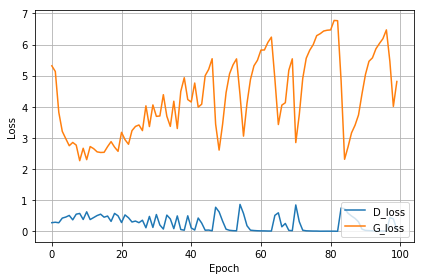

In [29]:
loss_plot(d_loss_hist, g_loss_hist)

## LSGAN

LSGAN(Least Squares GAN)将loss函数改为了 L2损失.G和D的优化目标如下图所示,
![lsgan](pictures/lsgan.png)
#### **作业**: 
在这里,请在下方补充L2Loss的代码来实现L2损失来优化上面的目标.并使用这个loss函数在mnist数据集上训练LSGAN,并显示训练的效果图片及loss变化曲线.

提示:忽略上图的1/2.L2损失即MSEloss(均方误差),传入两个参数input_是指判别器D预测为"真实"的概率值(size为batch_size\*1),target为标签1或0(size为batch_size\*1).只允许使用pytorch和python的运算实现(不能直接调用MSEloss)

In [16]:
class L2Loss(nn.Module):
    def __init__(self):
        super(L2Loss, self).__init__()
    
    def forward(self, input_, target):
        """
        input_: (batch_size*1) 
        target: (batch_size*1) labels, 1 or 0
        """
        return torch.mean((input_ - target) ** 2)
        """
        To Do
        """

完成上方代码后,使用所写的L2Loss训练DCGAN.

In [17]:
# hyper params

# z dim
latent_dim = 100

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 100
batch_size = 32

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# use L2Loss as loss function
l2loss = L2Loss().to(device)

# G and D model, use DCGAN
G = DCGenerator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel).to(device)
D = DCDiscriminator(image_size=image_size, input_channel=image_channel).to(device)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

Epoch 0: Train D loss: 0.0856, G loss: 0.9480


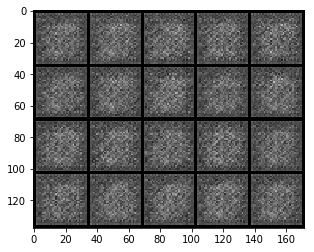

Epoch 1: Train D loss: 0.0074, G loss: 0.9774
Epoch 2: Train D loss: 0.0025, G loss: 0.9707
Epoch 3: Train D loss: 0.4778, G loss: 0.9856
Epoch 4: Train D loss: 1.0000, G loss: 1.0000
Epoch 5: Train D loss: 1.0000, G loss: 1.0000
Epoch 6: Train D loss: 1.0000, G loss: 1.0000
Epoch 7: Train D loss: 0.9999, G loss: 1.0000
Epoch 8: Train D loss: 0.9708, G loss: 0.4651
Epoch 9: Train D loss: 0.8048, G loss: 0.2546


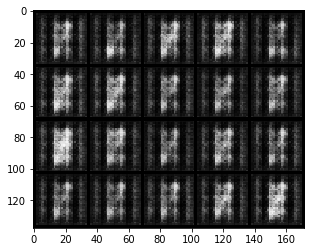

Epoch 10: Train D loss: 0.0827, G loss: 0.9487
Epoch 11: Train D loss: 0.1209, G loss: 0.8998
Epoch 12: Train D loss: 0.2001, G loss: 0.8049
Epoch 13: Train D loss: 0.2162, G loss: 0.7393
Epoch 14: Train D loss: 0.1458, G loss: 0.7601
Epoch 15: Train D loss: 0.1959, G loss: 0.7169
Epoch 16: Train D loss: 0.1894, G loss: 0.7070
Epoch 17: Train D loss: 0.1697, G loss: 0.7093
Epoch 18: Train D loss: 0.1638, G loss: 0.7053
Epoch 19: Train D loss: 0.1930, G loss: 0.6990


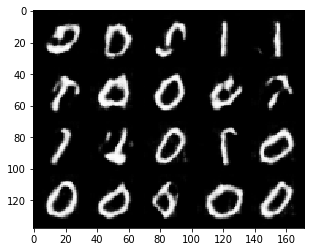

Epoch 20: Train D loss: 0.1789, G loss: 0.6977
Epoch 21: Train D loss: 0.1751, G loss: 0.6898
Epoch 22: Train D loss: 0.1997, G loss: 0.6916
Epoch 23: Train D loss: 0.1392, G loss: 0.7286
Epoch 24: Train D loss: 0.1739, G loss: 0.7084
Epoch 25: Train D loss: 0.1451, G loss: 0.7284
Epoch 26: Train D loss: 0.1917, G loss: 0.7136
Epoch 27: Train D loss: 0.1346, G loss: 0.7399
Epoch 28: Train D loss: 0.1312, G loss: 0.7492
Epoch 29: Train D loss: 0.1463, G loss: 0.7274


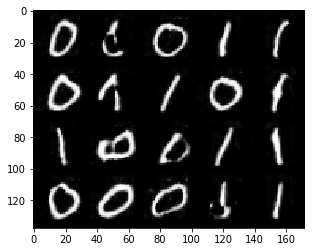

Epoch 30: Train D loss: 0.0916, G loss: 0.7762
Epoch 31: Train D loss: 0.1278, G loss: 0.7650
Epoch 32: Train D loss: 0.1213, G loss: 0.7826
Epoch 33: Train D loss: 0.1136, G loss: 0.7883
Epoch 34: Train D loss: 0.0762, G loss: 0.8160
Epoch 35: Train D loss: 0.1228, G loss: 0.7937
Epoch 36: Train D loss: 0.0720, G loss: 0.8277
Epoch 37: Train D loss: 0.0615, G loss: 0.8516
Epoch 38: Train D loss: 0.1145, G loss: 0.8285
Epoch 39: Train D loss: 0.0709, G loss: 0.8439


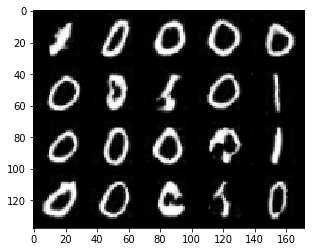

Epoch 40: Train D loss: 0.0660, G loss: 0.8441
Epoch 41: Train D loss: 0.1359, G loss: 0.8151
Epoch 42: Train D loss: 0.0306, G loss: 0.8762
Epoch 43: Train D loss: 0.0251, G loss: 0.8873
Epoch 44: Train D loss: 0.0919, G loss: 0.8672
Epoch 45: Train D loss: 0.0228, G loss: 0.8974
Epoch 46: Train D loss: 0.1588, G loss: 0.8368
Epoch 47: Train D loss: 0.0262, G loss: 0.8924
Epoch 48: Train D loss: 0.0156, G loss: 0.9096
Epoch 49: Train D loss: 0.0693, G loss: 0.8953


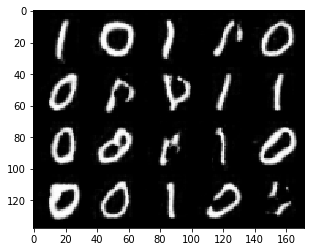

Epoch 50: Train D loss: 0.0729, G loss: 0.8764
Epoch 51: Train D loss: 0.0211, G loss: 0.9147
Epoch 52: Train D loss: 0.0215, G loss: 0.9086
Epoch 53: Train D loss: 0.0125, G loss: 0.9233
Epoch 54: Train D loss: 0.0161, G loss: 0.9262
Epoch 55: Train D loss: 0.0081, G loss: 0.9415
Epoch 56: Train D loss: 0.1395, G loss: 0.8458
Epoch 57: Train D loss: 0.0847, G loss: 0.8783
Epoch 58: Train D loss: 0.0169, G loss: 0.9284
Epoch 59: Train D loss: 0.0078, G loss: 0.9313


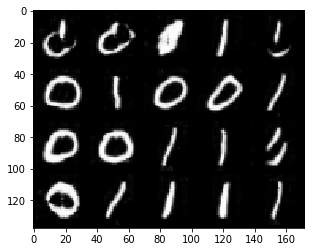

Epoch 60: Train D loss: 0.0056, G loss: 0.9446
Epoch 61: Train D loss: 0.0744, G loss: 0.8947
Epoch 62: Train D loss: 0.1870, G loss: 0.8498
Epoch 63: Train D loss: 0.0156, G loss: 0.9183
Epoch 64: Train D loss: 0.0066, G loss: 0.9464
Epoch 65: Train D loss: 0.0117, G loss: 0.9493
Epoch 66: Train D loss: 0.0052, G loss: 0.9475
Epoch 67: Train D loss: 0.0062, G loss: 0.9531
Epoch 68: Train D loss: 0.1286, G loss: 0.8731
Epoch 69: Train D loss: 0.1415, G loss: 0.8676


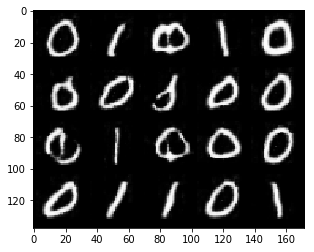

Epoch 70: Train D loss: 0.0132, G loss: 0.9641
Epoch 71: Train D loss: 0.0648, G loss: 0.9369
Epoch 72: Train D loss: 0.0153, G loss: 0.9328
Epoch 73: Train D loss: 0.0064, G loss: 0.9507
Epoch 74: Train D loss: 0.0041, G loss: 0.9540
Epoch 75: Train D loss: 0.0037, G loss: 0.9549
Epoch 76: Train D loss: 0.0026, G loss: 0.9630
Epoch 77: Train D loss: 0.0028, G loss: 0.9720
Epoch 78: Train D loss: 0.0038, G loss: 0.9581
Epoch 79: Train D loss: 0.0021, G loss: 0.9669


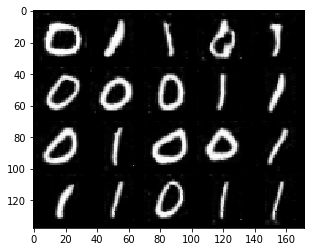

Epoch 80: Train D loss: 0.0020, G loss: 0.9697
Epoch 81: Train D loss: 0.0019, G loss: 0.9718
Epoch 82: Train D loss: 0.0012, G loss: 0.9798
Epoch 83: Train D loss: 0.2155, G loss: 0.8277
Epoch 84: Train D loss: 0.0079, G loss: 0.9464
Epoch 85: Train D loss: 0.0031, G loss: 0.9560
Epoch 86: Train D loss: 0.0028, G loss: 0.9740
Epoch 87: Train D loss: 0.0000, G loss: 1.0000
Epoch 88: Train D loss: 0.0000, G loss: 1.0000
Epoch 89: Train D loss: 0.0000, G loss: 1.0000


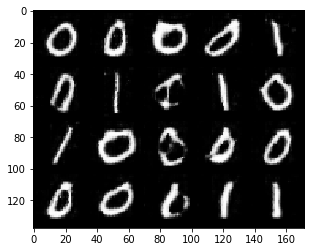

Epoch 90: Train D loss: 0.0000, G loss: 1.0000
Epoch 91: Train D loss: 0.0000, G loss: 1.0000
Epoch 92: Train D loss: 0.0000, G loss: 1.0000
Epoch 93: Train D loss: 0.0000, G loss: 1.0000
Epoch 94: Train D loss: 0.0000, G loss: 1.0000
Epoch 95: Train D loss: 0.0000, G loss: 1.0000
Epoch 96: Train D loss: 0.0000, G loss: 1.0000
Epoch 97: Train D loss: 0.0000, G loss: 0.9999
Epoch 98: Train D loss: 0.0000, G loss: 0.9999
Epoch 99: Train D loss: 0.0000, G loss: 0.9999


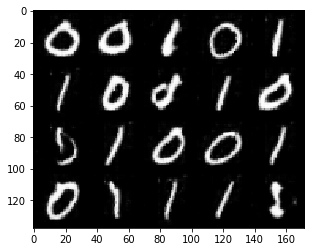

([0.08556876808294571,
  0.007397195968252841,
  0.0025208197575199254,
  0.4778314146488334,
  0.9999832331188141,
  0.9999785612499903,
  0.999968653633481,
  0.9999311774496048,
  0.9708349639845509,
  0.8048494075247574,
  0.08267661484165324,
  0.12087103884134974,
  0.2000907346133202,
  0.21623821580220784,
  0.14582476002119837,
  0.19589324600048483,
  0.18944406272873046,
  0.16974850921403795,
  0.16383659319272117,
  0.1929740204461037,
  0.17892850149008963,
  0.17505885016113992,
  0.19969984823985706,
  0.13916054291148033,
  0.1739022404191986,
  0.1450713018458041,
  0.19171994126268796,
  0.13460468985731638,
  0.13115119369375328,
  0.14631788745995553,
  0.09162557757799587,
  0.12784326023289136,
  0.12134237609626282,
  0.11364227465339123,
  0.07616739820629831,
  0.12280635475107128,
  0.07198753049744973,
  0.06149623562241831,
  0.11453725517328296,
  0.07089096613760505,
  0.06597527011578518,
  0.1358701449242376,
  0.0305556846072986,
  0.02513638814349496,

In [18]:
run_gan(trainloader, G, D, G_optimizer, D_optimizer, l2loss, n_epochs, device, latent_dim)

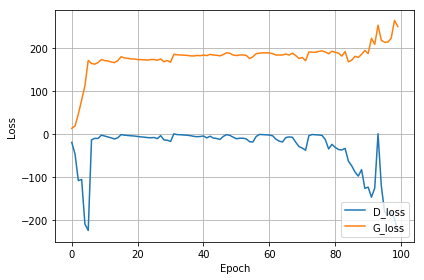

In [58]:
loss_plot(d_loss_hist, g_loss_hist)

## WGAN

WGAN(Wasserstein GAN)将传统GAN中拟合的JS散度改为Wasserstein距离.WGAN一定程度上解决了GAN训练不稳定以及模式奔溃(collapse mode,可以理解为生成的图片多样性极低)的问题.

具体到在实现上,WGAN主要有3点改变:
- 判别器D最后一层去掉sigmoid
- 生成器G和判别器的loss不使用log
- 每次更新判别器D后,将参数的绝对值截断到某一个固定常数c
所以我们主要重写了WGAN的训练函数,在这里,网络结构依然使用我们实现的DCGAN(注意初始化D时将sigmoid设置为False来去掉最后一层sigmoid).

下面是WGAN的代码实现.加入了两个参数,n_d表示每训练一次G训练D的次数,weight_clip表示截断的常数.


In [13]:
def wgan_train(trainloader, G, D, G_optimizer, D_optimizer, device, z_dim, n_d=2, weight_clip=0.01):
    
    """
    n_d: the number of iterations of D update per G update iteration
    weight_clip: the clipping parameters
    """
    
    D.train()
    G.train()
    
    D_total_loss = 0
    G_total_loss = 0
    
    params_list = []
    
    
    for i, (x, _) in enumerate(trainloader):
        y_real = torch.ones(x.size(0), 1).to(device)
        y_fake = torch.zeros(x.size(0), 1).to(device)
        
        x = x.to(device)
        z = torch.rand(x.size(0), z_dim).to(device)

        # update D network
        # D optimizer zero grads
        D_optimizer.zero_grad()
        
        # D real loss from real images
        d_real = D(x)
        d_real_loss = - d_real.mean()
        
        # D fake loss from fake images generated by G
        g_z = G(z)
        d_fake = D(g_z)
        d_fake_loss = d_fake.mean()
        
        # D backward and step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()
        
        # D params Weight Clip
        for params in D.parameters():
            params.data.clamp_(-weight_clip, weight_clip)
            
        D_total_loss += d_loss.item()

        # update G network
        if (i + 1) % n_d == 0:
            # G optimizer zero grads
            G_optimizer.zero_grad()

            # G loss
            g_z = G(z)
            d_fake = D(g_z)
            g_loss = - d_fake.mean()

            # G backward and step
            g_loss.backward()
            G_optimizer.step()
            
            G_total_loss += g_loss.item()
    
    return D_total_loss / len(trainloader), G_total_loss * n_d / len(trainloader)

再次尝试用mnist数据集来训练wgan.

Epoch 0: Train D loss: -0.2105, G loss: 0.1123


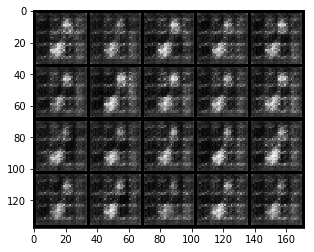

Epoch 1: Train D loss: -0.4763, G loss: 0.2794
Epoch 2: Train D loss: -0.4740, G loss: 0.3193
Epoch 3: Train D loss: -0.4671, G loss: 0.3162
Epoch 4: Train D loss: -0.4688, G loss: 0.2993
Epoch 5: Train D loss: -0.4380, G loss: 0.2798
Epoch 6: Train D loss: -0.3375, G loss: 0.2220
Epoch 7: Train D loss: -0.3207, G loss: 0.1815
Epoch 8: Train D loss: -0.3078, G loss: 0.2105
Epoch 9: Train D loss: -0.3084, G loss: 0.2106


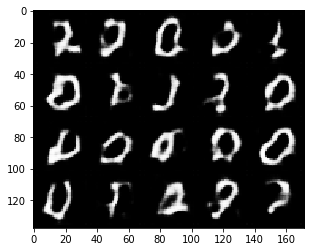

Epoch 10: Train D loss: -0.3091, G loss: 0.2185
Epoch 11: Train D loss: -0.3013, G loss: 0.2131
Epoch 12: Train D loss: -0.3159, G loss: 0.2271
Epoch 13: Train D loss: -0.2969, G loss: 0.2012
Epoch 14: Train D loss: -0.2996, G loss: 0.1900
Epoch 15: Train D loss: -0.2988, G loss: 0.2286
Epoch 16: Train D loss: -0.2864, G loss: 0.1469
Epoch 17: Train D loss: -0.2700, G loss: 0.1764
Epoch 18: Train D loss: -0.2828, G loss: 0.1727
Epoch 19: Train D loss: -0.2675, G loss: 0.2038


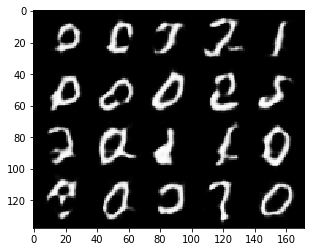

Epoch 20: Train D loss: -0.2698, G loss: 0.2248
Epoch 21: Train D loss: -0.2620, G loss: 0.2130
Epoch 22: Train D loss: -0.2500, G loss: 0.1611
Epoch 23: Train D loss: -0.2634, G loss: 0.1943
Epoch 24: Train D loss: -0.2466, G loss: 0.2136
Epoch 25: Train D loss: -0.2595, G loss: 0.1718
Epoch 26: Train D loss: -0.2452, G loss: 0.1820
Epoch 27: Train D loss: -0.2433, G loss: 0.1619
Epoch 28: Train D loss: -0.2349, G loss: 0.1583
Epoch 29: Train D loss: -0.2281, G loss: 0.1630


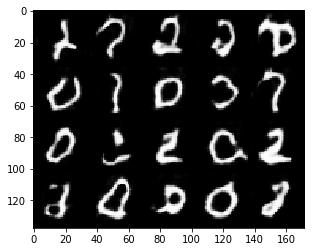

Epoch 30: Train D loss: -0.2359, G loss: 0.1465
Epoch 31: Train D loss: -0.2267, G loss: 0.1667
Epoch 32: Train D loss: -0.2204, G loss: 0.1609
Epoch 33: Train D loss: -0.2171, G loss: 0.1552
Epoch 34: Train D loss: -0.2203, G loss: 0.1444
Epoch 35: Train D loss: -0.2098, G loss: 0.1376
Epoch 36: Train D loss: -0.2187, G loss: 0.1692
Epoch 37: Train D loss: -0.2154, G loss: 0.1429
Epoch 38: Train D loss: -0.2072, G loss: 0.1493
Epoch 39: Train D loss: -0.2055, G loss: 0.1253


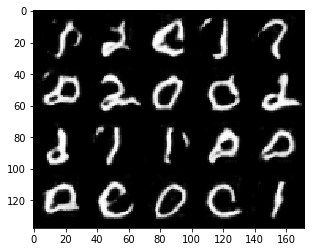

Epoch 40: Train D loss: -0.2078, G loss: 0.1414
Epoch 41: Train D loss: -0.2097, G loss: 0.1577
Epoch 42: Train D loss: -0.2059, G loss: 0.1491
Epoch 43: Train D loss: -0.2097, G loss: 0.1401
Epoch 44: Train D loss: -0.2093, G loss: 0.1599
Epoch 45: Train D loss: -0.2162, G loss: 0.1614
Epoch 46: Train D loss: -0.1980, G loss: 0.1593
Epoch 47: Train D loss: -0.2024, G loss: 0.1589
Epoch 48: Train D loss: -0.2155, G loss: 0.1951
Epoch 49: Train D loss: -0.2192, G loss: 0.2215


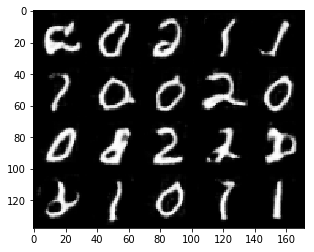

Epoch 50: Train D loss: -0.2091, G loss: 0.1661
Epoch 51: Train D loss: -0.2108, G loss: 0.1909
Epoch 52: Train D loss: -0.1996, G loss: 0.1401
Epoch 53: Train D loss: -0.2111, G loss: 0.1967
Epoch 54: Train D loss: -0.2036, G loss: 0.1313
Epoch 55: Train D loss: -0.2129, G loss: 0.1805
Epoch 56: Train D loss: -0.2031, G loss: 0.1291
Epoch 57: Train D loss: -0.2028, G loss: 0.1541
Epoch 58: Train D loss: -0.2034, G loss: 0.1443
Epoch 59: Train D loss: -0.2052, G loss: 0.1531


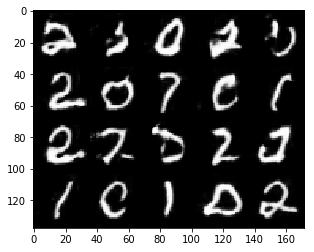

Epoch 60: Train D loss: -0.2001, G loss: 0.1280
Epoch 61: Train D loss: -0.2032, G loss: 0.1881
Epoch 62: Train D loss: -0.1983, G loss: 0.1203
Epoch 63: Train D loss: -0.2022, G loss: 0.1746
Epoch 64: Train D loss: -0.2017, G loss: 0.1769
Epoch 65: Train D loss: -0.1990, G loss: 0.1728
Epoch 66: Train D loss: -0.2045, G loss: 0.1686
Epoch 67: Train D loss: -0.1984, G loss: 0.1473
Epoch 68: Train D loss: -0.1948, G loss: 0.1872
Epoch 69: Train D loss: -0.1939, G loss: 0.1603


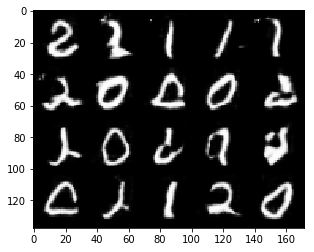

Epoch 70: Train D loss: -0.1954, G loss: 0.1584
Epoch 71: Train D loss: -0.1933, G loss: 0.1702
Epoch 72: Train D loss: -0.1870, G loss: 0.1650
Epoch 73: Train D loss: -0.1942, G loss: 0.1729
Epoch 74: Train D loss: -0.1893, G loss: 0.1402
Epoch 75: Train D loss: -0.1836, G loss: 0.1500
Epoch 76: Train D loss: -0.1910, G loss: 0.1355
Epoch 77: Train D loss: -0.1915, G loss: 0.1274
Epoch 78: Train D loss: -0.1889, G loss: 0.1774
Epoch 79: Train D loss: -0.1868, G loss: 0.1408


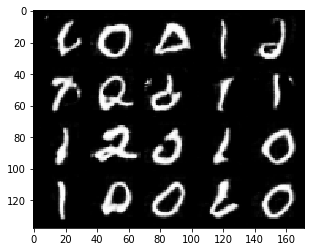

Epoch 80: Train D loss: -0.1843, G loss: 0.1362
Epoch 81: Train D loss: -0.1875, G loss: 0.1438
Epoch 82: Train D loss: -0.1803, G loss: 0.1505
Epoch 83: Train D loss: -0.1860, G loss: 0.1282
Epoch 84: Train D loss: -0.1831, G loss: 0.1436
Epoch 85: Train D loss: -0.1754, G loss: 0.1152
Epoch 86: Train D loss: -0.1835, G loss: 0.1476
Epoch 87: Train D loss: -0.1813, G loss: 0.1345
Epoch 88: Train D loss: -0.1849, G loss: 0.1384
Epoch 89: Train D loss: -0.1802, G loss: 0.1180


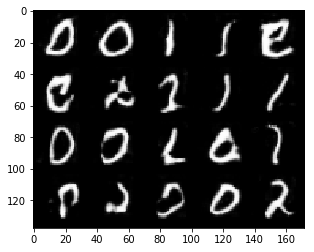

KeyboardInterrupt: 

In [31]:
# hyper params

# z dim
latent_dim = 100

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 100
batch_size = 32

# n_d: the number of iterations of D update per G update iteration
n_d = 2
weight_clip=0.01

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# G and D model, use DCGAN, note that Sigmoid is removed in D 
G = DCGenerator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel).to(device)
D = DCDiscriminator(image_size=image_size, input_channel=image_channel, sigmoid=False).to(device)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

d_loss_hist = []
g_loss_hist = []

for epoch in range(n_epochs):
    d_loss, g_loss = wgan_train(trainloader, G, D, G_optimizer, D_optimizer, device, 
                           z_dim=latent_dim, n_d=n_d, weight_clip=weight_clip)
    print('Epoch {}: Train D loss: {:.4f}, G loss: {:.4f}'.format(epoch, d_loss, g_loss))
    
    d_loss_hist.append(d_loss)
    g_loss_hist.append(g_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        visualize_results(G, device, latent_dim)

由WGAN的原理我们知道,D_loss的*相反数*可以表示生成数据分布与真实分布的Wasserstein距离,其数值越小,表明两个分布越相似,GAN训练得越好.它的值给我们训练GAN提供了一个指标.

运行下方代码观察wgan的loss曲线,可以看到,总体上,D_loss的*相反数*随着epoch数增加逐渐下降,同时生成的数据也越来越逼近真实数据,这与wgan的原理是相符合的.

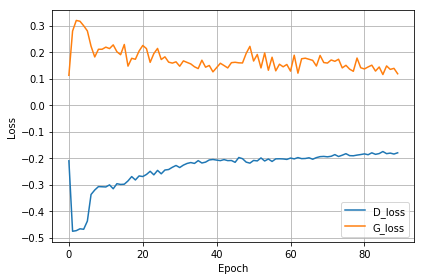

In [32]:
loss_plot(d_loss_hist, g_loss_hist)

接下来运行下面两个cell的代码,集中展示wgan的参数分布.可以看到,参数都被截断在\[-c, c\]之间,大部分参数集中在-c和c附近.

In [2]:
from utils import show_weights_hist
def show_d_params(D):
    plist = []
    for params in D.parameters():
        plist.extend(params.cpu().data.view(-1).numpy())
    show_weights_hist(plist)

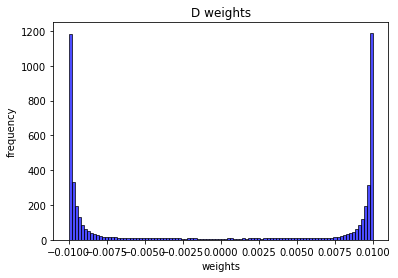

In [32]:
show_d_params(D)

## WGAN-GP(improved wgan)

在WGAN中，需要进行截断, 在实验中发现： 对于比较深的WAGN，它不容易收敛。

大致原因如下：
1. 实验发现最后大多数的权重都在-c 和c上，这就意味了大部分权重只有两个可能数，这太简单了，作为一个深度神经网络来说，这实在是对它强大的拟合能力的浪费。
2. 实验发现容易导致梯度消失或梯度爆炸。我们知道，w1w1的梯度的一个因子是w2w2, w2w2的梯度的因子是w3w3. 若 w>0.1w>0.1，它被clip后，w变小了，导致梯度变小，多层传递，容易导致梯度消失；反之，若w<−0.1w<−0.1, 被clip后，w变大，则容易导致梯度爆炸。

所以WGAN-GP使用了Gradient penalty(梯度惩罚）来代替clip.
因为Lipschitz限制是要求判别器的梯度不超过K,所以可以直接使用一个loss term来实现这一点,所以改进后D的优化目标改进为如下:
![wgan_gp](pictures/wgan-gp.svg)

下面是WGAN-GP的具体代码实现,同WGAN,我们也只实现了他的训练代码,而模型我们直接使用DCGAN的模型.

In [18]:
import torch.autograd as autograd

def wgan_gp_train(trainloader, G, D, G_optimizer, D_optimizer, device, z_dim, lambda_=10, n_d=2):
    
    D.train()
    G.train()
    
    D_total_loss = 0
    G_total_loss = 0
    
    
    for i, (x, _) in enumerate(trainloader):
        y_real = torch.ones(x.size(0), 1).to(device)
        y_fake = torch.zeros(x.size(0), 1).to(device)
        
        x = x.to(device)
        z = torch.rand(x.size(0), z_dim).to(device)

        # update D network
        # D optimizer zero grads
        D_optimizer.zero_grad()
        
        # D real loss from real images
        d_real = D(x)
        d_real_loss = - d_real.mean()
        
        # D fake loss from fake images generated by G
        g_z = G(z)
        d_fake = D(g_z)
        d_fake_loss = d_fake.mean()
        
        # D gradient penalty
        
        #   a random number epsilon
        epsilon = torch.rand(x.size(0), 1, 1, 1).cuda()
        x_hat = epsilon * x + (1 - epsilon) * g_z
        x_hat.requires_grad_(True)

        y_hat = D(x_hat)
        #   computes the sum of gradients of y_hat with regard to x_hat
        gradients = autograd.grad(outputs=y_hat, inputs=x_hat, grad_outputs=torch.ones(y_hat.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        #   computes gradientpenalty
        gradient_penalty =  torch.mean((gradients.view(gradients.size()[0], -1).norm(p=2, dim=1) - 1) ** 2)
        
        # D backward and step
        d_loss = d_real_loss + d_fake_loss + lambda_ * gradient_penalty
        d_loss.backward()
        D_optimizer.step()
        
            
        D_total_loss += d_loss.item()

        # update G network
        # G optimizer zero grads
        if (i + 1) % n_d == 0:
            G_optimizer.zero_grad()

            # G loss
            g_z = G(z)
            d_fake = D(g_z)
            g_loss = - d_fake.mean()

            # G backward and step
            g_loss.backward()
            G_optimizer.step()
            
            G_total_loss += g_loss.item()
    
    return D_total_loss / len(trainloader), G_total_loss * n_d / len(trainloader)

Epoch 0: Train D loss: -19.6475, G loss: 11.8697


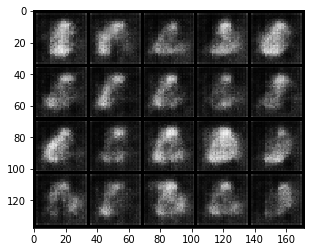

Epoch 1: Train D loss: -45.1117, G loss: 17.8739
Epoch 2: Train D loss: -109.7314, G loss: 53.3327
Epoch 3: Train D loss: -187.4243, G loss: 100.2440
Epoch 4: Train D loss: -301.4703, G loss: 162.5980
Epoch 5: Train D loss: -503.8266, G loss: 245.9919
Epoch 6: Train D loss: -124.4604, G loss: 303.8820
Epoch 7: Train D loss: -7.7494, G loss: 295.0617
Epoch 8: Train D loss: -6.7262, G loss: 294.3085
Epoch 9: Train D loss: -5.6316, G loss: 292.8590


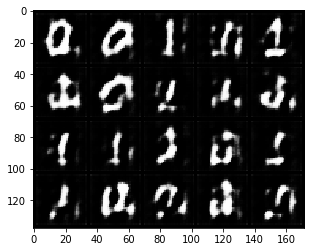

Epoch 10: Train D loss: -5.8750, G loss: 292.1902
Epoch 11: Train D loss: -6.7687, G loss: 292.0032
Epoch 12: Train D loss: -8.1572, G loss: 291.6290
Epoch 13: Train D loss: -8.5141, G loss: 291.6045
Epoch 14: Train D loss: -8.6309, G loss: 292.1334
Epoch 15: Train D loss: -5.1756, G loss: 297.0012
Epoch 16: Train D loss: -6.6071, G loss: 295.1090
Epoch 17: Train D loss: -9.6731, G loss: 291.5963
Epoch 18: Train D loss: -10.8899, G loss: 292.0443
Epoch 19: Train D loss: -8.8052, G loss: 295.1225


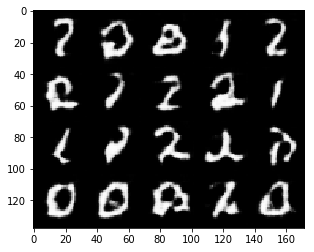

Epoch 20: Train D loss: -11.4258, G loss: 291.6016
Epoch 21: Train D loss: -2.6288, G loss: 296.1117
Epoch 22: Train D loss: -4.8196, G loss: 293.7514
Epoch 23: Train D loss: -6.5466, G loss: 293.8261
Epoch 24: Train D loss: -7.6290, G loss: 291.9867
Epoch 25: Train D loss: -8.1627, G loss: 290.9585
Epoch 26: Train D loss: -9.6249, G loss: 290.5616
Epoch 27: Train D loss: -10.3790, G loss: 290.6720
Epoch 28: Train D loss: -7.7292, G loss: 286.1069
Epoch 29: Train D loss: -10.0821, G loss: 284.9586


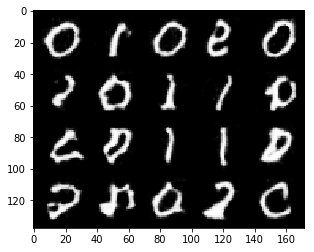

Epoch 30: Train D loss: -13.3224, G loss: 287.1424
Epoch 31: Train D loss: -13.1360, G loss: 286.3752
Epoch 32: Train D loss: -15.6797, G loss: 281.4284
Epoch 33: Train D loss: -14.6919, G loss: 284.9458
Epoch 34: Train D loss: -17.6784, G loss: 279.6885
Epoch 35: Train D loss: -15.5629, G loss: 282.4400
Epoch 36: Train D loss: 0.4669, G loss: 281.1756
Epoch 37: Train D loss: -1.0062, G loss: 280.6519
Epoch 38: Train D loss: -1.7166, G loss: 281.6402
Epoch 39: Train D loss: -2.9192, G loss: 279.3571


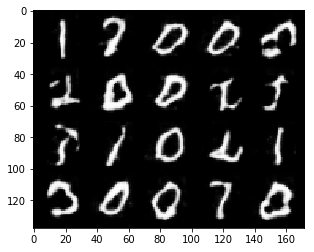

Epoch 40: Train D loss: -5.4834, G loss: 278.5517
Epoch 41: Train D loss: -8.3677, G loss: 278.6014
Epoch 42: Train D loss: -10.5028, G loss: 276.5476
Epoch 43: Train D loss: -13.5200, G loss: 274.1525
Epoch 44: Train D loss: -14.8716, G loss: 273.4147
Epoch 45: Train D loss: -8.8930, G loss: 280.9705
Epoch 46: Train D loss: -4.7560, G loss: 281.1554
Epoch 47: Train D loss: -10.4884, G loss: 281.6221
Epoch 48: Train D loss: -12.7654, G loss: 282.4338
Epoch 49: Train D loss: -4.7234, G loss: 282.8072


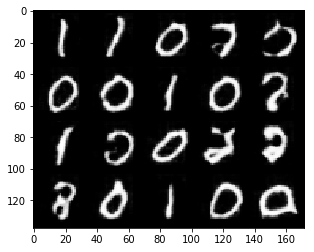

Epoch 50: Train D loss: -2.2530, G loss: 284.1669
Epoch 51: Train D loss: -10.5303, G loss: 280.7902
Epoch 52: Train D loss: -15.7553, G loss: 280.7194
Epoch 53: Train D loss: -7.3431, G loss: 282.0270
Epoch 54: Train D loss: -1.7122, G loss: 285.0031
Epoch 55: Train D loss: -2.7434, G loss: 285.3790
Epoch 56: Train D loss: -11.9381, G loss: 278.8571
Epoch 57: Train D loss: -9.0983, G loss: 273.6086
Epoch 58: Train D loss: -4.2453, G loss: 274.7316
Epoch 59: Train D loss: -1.0808, G loss: 279.4638


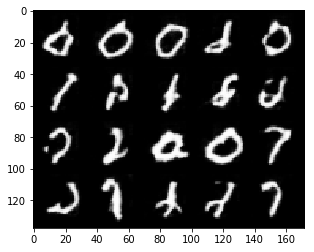

Epoch 60: Train D loss: -1.5560, G loss: 281.4627
Epoch 61: Train D loss: -1.9634, G loss: 281.8177
Epoch 62: Train D loss: -2.4713, G loss: 281.4067
Epoch 63: Train D loss: -5.1466, G loss: 278.8978
Epoch 64: Train D loss: -6.7202, G loss: 281.7752
Epoch 65: Train D loss: -3.1559, G loss: 278.4153
Epoch 66: Train D loss: -11.1891, G loss: 280.0034
Epoch 67: Train D loss: -13.9842, G loss: 280.3603
Epoch 68: Train D loss: -18.0843, G loss: 280.7129
Epoch 69: Train D loss: -23.1686, G loss: 276.8252


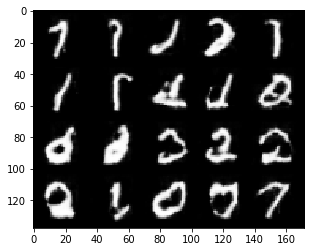

Epoch 70: Train D loss: -20.0322, G loss: 274.7166
Epoch 71: Train D loss: -27.8108, G loss: 278.0054
Epoch 72: Train D loss: -30.5044, G loss: 274.8570
Epoch 73: Train D loss: -30.6957, G loss: 278.2365
Epoch 74: Train D loss: -36.9412, G loss: 269.6086
Epoch 75: Train D loss: -37.1386, G loss: 275.5252
Epoch 76: Train D loss: -2.3917, G loss: 291.8013
Epoch 77: Train D loss: -28.8156, G loss: 276.9884
Epoch 78: Train D loss: -6.0481, G loss: 283.4698
Epoch 79: Train D loss: -2.8659, G loss: 287.2821


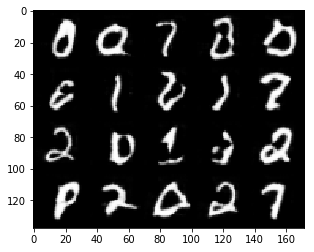

Epoch 80: Train D loss: -45.4211, G loss: 276.2064
Epoch 81: Train D loss: -38.5356, G loss: 278.2461
Epoch 82: Train D loss: -47.3056, G loss: 277.3482
Epoch 83: Train D loss: -58.5710, G loss: 280.3901
Epoch 84: Train D loss: -57.0131, G loss: 273.7658
Epoch 85: Train D loss: -69.4920, G loss: 276.2447
Epoch 86: Train D loss: -74.7928, G loss: 276.6262
Epoch 87: Train D loss: -56.1880, G loss: 291.3961
Epoch 88: Train D loss: -37.3218, G loss: 303.8371
Epoch 89: Train D loss: -6.1330, G loss: 316.0927


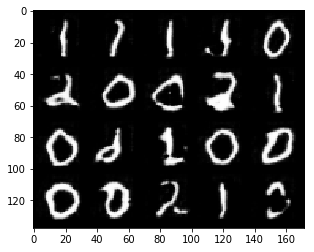

Epoch 90: Train D loss: -41.0591, G loss: 307.2375
Epoch 91: Train D loss: -84.4037, G loss: 289.1329
Epoch 92: Train D loss: -90.7180, G loss: 294.7061
Epoch 93: Train D loss: -94.5125, G loss: 301.2960
Epoch 94: Train D loss: -118.4657, G loss: 300.1948
Epoch 95: Train D loss: -126.0640, G loss: 301.2677
Epoch 96: Train D loss: -112.6039, G loss: 298.5160
Epoch 97: Train D loss: -136.1206, G loss: 307.8859
Epoch 98: Train D loss: -53.5955, G loss: 346.7832
Epoch 99: Train D loss: -2.6491, G loss: 349.0484


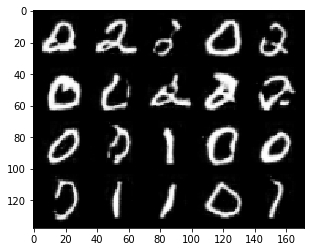

In [19]:
# hyper params

# z dim
latent_dim = 100

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 100
batch_size = 32

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# n_d: train D
n_d = 2
lambda_ = 10

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# G and D model, use DCGAN, note that Sigmoid is removed in D 
G = DCGenerator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel).to(device)
D = DCDiscriminator(image_size=image_size, input_channel=image_channel, sigmoid=False).to(device)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

d_loss_hist = []
g_loss_hist = []

for epoch in range(n_epochs):
    d_loss, g_loss = wgan_gp_train(trainloader, G, D, G_optimizer, D_optimizer, device, 
                           z_dim=latent_dim, lambda_=lambda_, n_d=n_d)
    print('Epoch {}: Train D loss: {:.4f}, G loss: {:.4f}'.format(epoch, d_loss, g_loss))
    
    d_loss_hist.append(d_loss)
    g_loss_hist.append(g_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        visualize_results(G, device, latent_dim)

同理,观察loss曲线和D上的参数分布.

In [ ]:
loss_plot(d_loss_hist, g_loss_hist)

/home/jiabin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


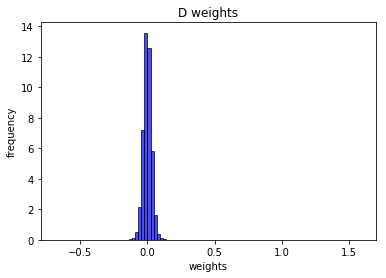

In [50]:
show_d_params(D)

#### **作业**: 
观察WGAN和WGAN-GP生成器生成的图片效果,它们在相同epoch时生成的图片效果,它们的loss曲线以及D的参数分布,说说有什么不同?

**答**: